Epoch 0, Loss = 38.128
Epoch 50, Loss = 0.911
Epoch 100, Loss = 0.058
Epoch 150, Loss = 0.046
Epoch 200, Loss = 0.022
Epoch 250, Loss = 0.014
✅ Training completed.


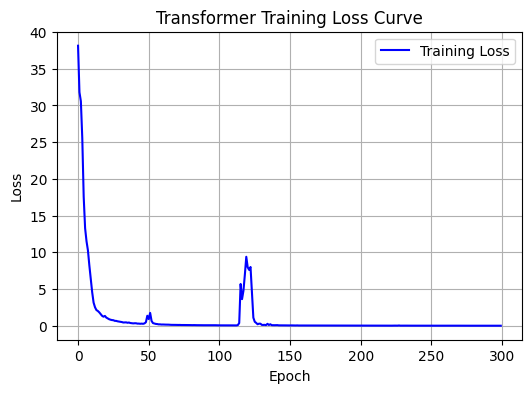


--- 🧪 TEST ---
EN: i eat rice
FR (pred): je t'aime
FR (true): je mange du riz
----------------------------------------
EN: you play football
FR (pred): je t'aime
FR (true): tu joues au football
----------------------------------------
EN: love they movies
FR (pred): je t'aime
FR (true): ils aiment les films
----------------------------------------
EN: he cats likes
FR (pred): je t'aime
FR (true): il aime les chats
----------------------------------------
EN: we water drink
FR (pred): je t'aime
FR (true): nous buvons de l'eau
----------------------------------------
EN: she reads books
FR (pred): je t'aime
FR (true): elle lit des livres
----------------------------------------
EN: kind they are
FR (pred): je t'aime
FR (true): ils sont gentils
----------------------------------------
EN: you watch movies
FR (pred): je t'aime
FR (true): tu regardes des films
----------------------------------------
EN: i good am
FR (pred): je t'aime
FR (true): je suis bon
--------------------------------

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Transformer
import math
import matplotlib.pyplot as plt
import random


train_en = [
    "i love you", "he is good", "she is kind", "we play football",
    "they eat rice", "you are smart", "i like cats", "he reads books",
    "she drinks water", "we watch movies"
]
train_fr = [
    "je t'aime", "il est bon", "elle est gentille", "nous jouons au football",
    "ils mangent du riz", "tu es intelligent", "j'aime les chats",
    "il lit des livres", "elle boit de l'eau", "nous regardons des films"
]

test_en = [
    "i eat rice", "you play football", "they love movies", "he likes cats",
    "we drink water", "she reads books", "they are kind",
    "you watch movies", "i am good", "we love you"
]
test_fr = [
    "je mange du riz", "tu joues au football", "ils aiment les films", "il aime les chats",
    "nous buvons de l'eau", "elle lit des livres", "ils sont gentils",
    "tu regardes des films", "je suis bon", "nous t'aimons"
]


vocab_en = {"<pad>":0, "<bos>":1, "<eos>":2}
vocab_fr = {"<pad>":0, "<bos>":1, "<eos>":2}
for s in train_en + test_en:
    for w in s.split(): vocab_en.setdefault(w, len(vocab_en))
for s in train_fr + test_fr:
    for w in s.split(): vocab_fr.setdefault(w, len(vocab_fr))

def encode(sentence, vocab):
    tokens = [vocab["<bos>"]] + [vocab[w] for w in sentence.split()] + [vocab["<eos>"]]
    return torch.tensor(tokens)

train_data = [(encode(e, vocab_en), encode(f, vocab_fr)) for e,f in zip(train_en, train_fr)]
test_data = [(encode(e, vocab_en), f) for e,f in zip(test_en, test_fr)]


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class TranslationTransformer(nn.Module):
    def __init__(self, vocab_in, vocab_out, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.embedding_in = nn.Embedding(len(vocab_in), d_model)
        self.embedding_out = nn.Embedding(len(vocab_out), d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = Transformer(d_model, nhead, num_layers, num_layers)
        self.fc_out = nn.Linear(d_model, len(vocab_out))

    def forward(self, src, tgt):
        src = self.embedding_in(src).unsqueeze(1)
        tgt = self.embedding_out(tgt).unsqueeze(1)
        src = self.pos_encoder(src)
        tgt = self.pos_encoder(tgt)
        output = self.transformer(src, tgt)
        return self.fc_out(output)

model = TranslationTransformer(vocab_en, vocab_fr)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []
for epoch in range(300):
    total_loss = 0
    for src, tgt in train_data:
        optimizer.zero_grad()
        output = model(src, tgt[:-1])
        loss = criterion(output.reshape(-1, output.size(-1)), tgt[1:].reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss = {total_loss:.3f}")

print("✅ Training completed.")

# =============================
# 6️⃣ VẼ BIỂU ĐỒ LOSS
# =============================
plt.figure(figsize=(6,4))
plt.plot(losses, label="Training Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Transformer Training Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("loss_plot.png")
plt.show()

inv_vocab_fr = {v:k for k,v in vocab_fr.items()}

def translate(model, sentence):
    model.eval()
    src = encode(sentence, vocab_en)
    tgt = torch.tensor([vocab_fr["<bos>"]])
    for _ in range(12):  # giới hạn độ dài
        with torch.no_grad():
            output = model(src, tgt)
            next_token = output[-1].argmax(dim=-1)
            tgt = torch.cat([tgt, next_token])
            if next_token.item() == vocab_fr["<eos>"]:
                break
    return " ".join(inv_vocab_fr[i.item()] for i in tgt[1:-1])

print("\n--- 🧪 TEST ---")
for src, tgt_ref in test_data:
    src_text = " ".join([k for k,v in vocab_en.items() if v in src and v > 2])
    tgt_pred = translate(model, src_text)
    print(f"EN: {src_text}")
    print(f"FR (pred): {tgt_pred}")
    print(f"FR (true): {tgt_ref}")
    print("-" * 40)
